# Introduction to pyiron for LAMMPS users

Author: [jan-janssen](https://jan-janssen.com)

The [pyiron framework](https://pyiron.org) enables rapid prototyping and up-scaling of simulation protocols. In pyiron simulation protocols are developed in jupyter notebooks using the Python programming language. This has two advantages, on the one hand documentation, code and results can be combined in the same document to maintain their provenance and on the other hand the user no longer has to switch between different interfaces, setting up the calculation, submitting it to an high performance computing (HPC) cluster and analysing the results of the finished calculation can all be done in the same document.

While LAMMPS already has a Python interface to access the [LAMMPS library](https://docs.lammps.org/Python_module.html) from Python as well as the ability to call [Python within your LAMMPS simulation protocol](https://docs.lammps.org/Python_call.html), pyiron adds an abstraction layer on top of this functionality. In particular pyiron provides job management and data management for LAMMPS calculation. This enables users to run parameter studies over hundreds or thousands of parameters. Consequently, pyiron is very beneficial to up-scale simulation protocols to iterate over the periodic table and identify chemical trends. 

To learn more about pyiron:
* https://doi.org/10.1016/j.commatsci.2018.07.043
* https://pyiron.org
* https://github.com/pyiron

This tutorial covers the basic usage of the pyiron framework: 
* Create a new project in pyiron 
* Create an atomistic structure
* Visualize an atomistic structure
* Run a LAMMPS calculation with pyiron
* Plot the results of a LAMMPS calculation

# Auto completion in Jupyter
By default Jupyter only supports one level of tab-based auto completion. This restriction is introduced to prevent Python packages to execute code without the users intent. Still for pyiron this functionality simplifies the interactive development so we re-enable it here: 

In [1]:
%config IPCompleter.evaluation='unsafe'

# Create a new project in pyiron

To simplify the use of pyiron inside jupyter notebooks, the pyiron framework only requires a single import statement. As LAMMPS is an atomistic simulation code, we are going to import the `Project` class from the `pyiron_atomistics` module.

In [2]:
from pyiron_atomistics import Project

The `Project` class in pyiron behaves just like a folder on the filesystem. In contrast to other workflow systems in pyiron the user does not have to interact with the underlying database directly but rather pyiron leverages the filesystem to structure individual calculation into projects. So we can create a first project named `test` to get started.

In [3]:
pr = Project(path="test")

For validation we can use the `ls` command on the commandline to see that the project folder named test was actually created: 

In [4]:
!ls

1-getting_started_with_pyiron.ipynb    _config.yml  pyiron.log	_toc.yml
2-data-driven-materials-science.ipynb  pyiron	    README.md
3-implement-new-job-classes.ipynb      pyiron.db    test


In addition to creating new projects, the project class can also be used to list the calculation inside a given project `pr.job_table()` and delete the calculation inside a given project `pr.remove_jobs()` if you want to start fresh. The goal of the database in pyiron is store all the calculation that you executed, so if you execute the same jupyter notebook again the results are reloaded rather than being recalculated. Still for this example we are going to delete all existing calculation:

In [5]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,aborted,Al4,lmp,/lmp,/home/jovyan/,test/,2025-06-11 14:52:05.371740,None,None,pyiron@jupyter-pyiron-workshop-l-tutorial-2025-mwp8tt12#2#flux,Lammps,0.1,None,None


In [6]:
pr.remove_jobs(silently=True)

  0%|          | 0/1 [00:00<?, ?it/s]

# Atomistic structures

After the `Project` class the next object we want to introduce is the atomistic structure object. The pyiron atomistic structure is base on the `ase.atoms.Atom` class from the [atomic simulation environment (ASE)](https://wiki.fysik.dtu.dk/ase/). 

## Create an atomistic structure

For demonstration purposes we create a bulk aluminium structure. Rather than having to import a separate module to create the structure object, in pyiron we can use the `Project` instance defined above and then use autocompletion (by clicking `<tab>` on your keyboard) to select the `pr.create.structure.ase.bulk()` function. The function takes an element as input and in addition we use the optional parameter `cubic=True` to generate a cubic aluminium cell.  

In [7]:
structure = pr.create.structure.ase.bulk(name="Al", cubic=True)

## Visualize an atomistic structure

Another focus of pyiron is to represent each pyiron object inside the jupyter environment. So in addtion to the string based representation from ASE you can use the `plot3d()` function of the structure object to visualize it using the [Nglview](http://nglviewer.org/nglview/latest/) package. The Nglview package provides a fully interactive visualization integrated in the jupyter notebook environment.  

In [8]:
structure

Al: [0. 0. 0.]
Al: [0.    2.025 2.025]
Al: [2.025 0.    2.025]
Al: [2.025 2.025 0.   ]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([4.05, 4.05, 4.05])

In [9]:
structure.plot3d()

NGLWidget()

# Run a LAMMPS calculation with pyiron

After creating the structure object, the next step is setting up the LAMMPS calculation. In pyiron individual calculation are called `jobs`. So we can create a LAMMPS object, in analogy to creating an atomistic structure object, using `pr.create.job.Lammps()`. The create job function takes a `job_name` as input argument. This `job_name` is used in the pyiron database to differentiate individual calculation and to allow pyiron to reload existing calculation. 

In [10]:
lmp = pr.create.job.Lammps(job_name="lmp")

## Assign the atomistic structure to the LAMMPS calculation

In the next step we can assign the atomistic structure `structure` created above to the LAMMPS calculation. By setting the `structure` property of the LAMMPS job object:

In [11]:
lmp.structure = structure

## Select an interatomic potential for the LAMMPS calculation

After the atomistic structure is assigned to the LAMMPS job object, pyiron is internally aware of the elements of the structure. In this particular case pyiron knows an aluminium structure was assinged. So when we want to select an interatomic potential, pyiron automatically queries both the [NIST database](https://www.ctcms.nist.gov/potentials/) as well as the [OpenKIM database](https://openkim.org) to list available interatomic potentials for aluminium. All this is done with the simple `lmp.list_potentials()` call. Alternatively, you can also use the `lmp.view_potentials()` function to get more details about the individual potentials: 

In [12]:
lmp.list_potentials()

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1',
 '1999--Mishin-Y--Al--LAMMPS--ipr1',
 '2000--Landa-A--Al-Pb--LAMMPS--ipr1',
 '2000--Sturgeon-J-B--Al--LAMMPS--ipr1',
 '2002--Mishin-Y--Ni-Al--LAMMPS--ipr1',
 '2003--Lee-B-J--Al--LAMMPS--ipr1',
 '2003--Zope-R-R--Al--LAMMPS--ipr1',
 '2003--Zope-R-R--Ti-Al--LAMMPS--ipr1',
 '2004--Liu-X-Y--Al--LAMMPS--ipr1',
 '2004--Mishin-Y--Ni-Al--LAMMPS--ipr1',
 '2004--Mishin-Y--Ni-Al--LAMMPS--ipr2',
 '2004--Zhou-X-W--Al--LAMMPS--ipr2',
 '2004--Zhou-X-W--Cu-Ag-Au-Ni-Pd-Pt-Al-Pb-Fe-Mo-Ta-W-Mg-Co-Ti-Zr--LAMMPS--ipr1',
 '2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1',
 '2007--Silva-A-C--Al-Ni--LAMMPS--ipr1',
 '2008--Mendelev-M-I--Al--LAMMPS--ipr1',
 '2009--Kim-Y-M--Mg-Al--LAMMPS--ipr1',
 '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1',
 '2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1',
 '2009--Zhakhovskii-V-V--Al--LAMMPS--i

In [13]:
lmp.view_potentials()

,Config,Filename,Model,Name,Species,Citations
39,"[pair_style eam/alloy\n, pair_coeff * * NiAlH_jea.eam.alloy Ni Al H\n]",[potential_LAMMPS/1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1/NiAlH_jea.eam.alloy],NISTiprpy,1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1,"[Ni, Al, H]","[{'Angelo_1995': {'title': 'Trapping of hydrogen to lattice defects in nickel', 'journal': 'Modelling and Simulation in Materials Science and Engineering', 'volume': '3', 'pages': '289--307', 'num..."
40,"[pair_style eam/alloy\n, pair_coeff * * Farkas_Nb-Ti-Al_1996.eam.alloy Nb Ti Al\n]",[potential_LAMMPS/1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1/Farkas_Nb-Ti-Al_1996.eam.alloy],NISTiprpy,1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1,"[Nb, Ti, Al]","[{'Farkas_1996': {'title': 'Interatomic potentials for ternary Nb - Ti - Al alloys', 'journal': 'Modelling and Simulation in Materials Science and Engineering', 'volume': '4', 'pages': '23--32', '..."
43,"[pair_style eam/alloy\n, pair_coeff * * mg-al-set.eam.alloy Al Mg\n]",[potential_LAMMPS/1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1/mg-al-set.eam.alloy],NISTiprpy,1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1,"[Al, Mg]","[{'Liu_1997': {'title': 'Anisotropic surface segregation in Al-Mg alloys', 'journal': 'Surface Science', 'volume': '373', 'pages': '357--370', 'number': '2-3', 'doi': '10.1016/s0039-6028(96)01154-..."
46,"[pair_style eam/alloy\n, pair_coeff * * almg.liu.eam.alloy Al Mg\n]",[potential_LAMMPS/1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1/almg.liu.eam.alloy],NISTiprpy,1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1,"[Al, Mg]","[{'Liu_1998': {'title': 'Grain-boundary segregation in Al-10%Mg alloys at hot working temperatures', 'journal': 'Acta Materialia', 'volume': '46', 'pages': '3467--3476', 'number': '10', 'doi': '10..."
48,"[pair_style eam/alloy\n, pair_coeff * * al-cu-set.eam.alloy Al Cu\n]",[potential_LAMMPS/1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1/al-cu-set.eam.alloy],NISTiprpy,1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1,"[Al, Cu]","[{'Liu_1999': {'title': ""A new investigation of copper's role in enhancing Al-Cu interconnect electromigration resistance from an atomistic view"", 'journal': 'Acta Materialia', 'volume': '47', 'pa..."
...,...,...,...,...,...,...
977,"[pair_style kim Sim_LAMMPS_MEAM_JelinekGrohHorstemeyer_2012_AlSiMgCuFe__SM_656517352485_000\n, pair_coeff * * Al Si Mg Cu Fe\n]",[],OPENKIM,Sim_LAMMPS_MEAM_JelinekGrohHorstemeyer_2012_AlSiMgCuFe__SM_656517352485_000,"[Al, Si, Mg, Cu, Fe]","[{'B._2012': {'title': 'Modified embedded atom method potential for Al, Si, Mg, Cu, and Fe alloys', 'volume': '85', 'year': '2012', 'journal': 'Physical Review B', 'doi': '10.1103/PhysRevB.85.2451..."
987,"[pair_style kim Sim_LAMMPS_MEAM_PascuetFernandez_2015_AlU__SM_721930391003_000\n, pair_coeff * * Al U\n]",[],OPENKIM,Sim_LAMMPS_MEAM_PascuetFernandez_2015_AlU__SM_721930391003_000,"[Al, U]","[{'M.I._2015': {'title': '{A}tomic interaction of the {MEAM} type for the study of intermetallics in the {A}l–{U} alloy', 'volume': '467', 'year': '2015', 'journal': 'Journal of Nuclear Materials'..."
988,"[pair_style kim Sim_LAMMPS_MEAM_PascuetFernandez_2015_Al__SM_811588957187_000\n, pair_coeff * * Al\n]",[],OPENKIM,Sim_LAMMPS_MEAM_PascuetFernandez_2015_Al__SM_811588957187_000,[Al],"[{'M.I._2015': {'title': '{A}tomic interaction of the {MEAM} type for the study of intermetallics in the {A}l–{U} alloy', 'volume': '467', 'year': '2015', 'journal': 'Journal of Nuclear Materials'..."
1008,"[pair_style kim Sim_LAMMPS_SMTBQ_SallesPolitanoAmzallag_2016_AlO__SM_853967355976_000\n, pair_coeff * * Al O\n]",[],OPENKIM,Sim_LAMMPS_SMTBQ_SallesPolitanoAmzallag_2016_AlO__SM_853967355976_000,"[Al, O]","[{'N._2016': {'title': 'Molecular dynamics study of high-pressure alumina polymorphs with a tight-binding variable-charge model', 'volume': '111', 'year': '2016', 'journal': 'Computational Materia..."


To assign a specific interatomic potential for our LAMMPS calculation, we can simply set the name of the potential as a parameter to the `potential` property of the LAMMPS job object:

In [14]:
lmp.potential = '2002--Mishin-Y--Ni-Al--LAMMPS--ipr1'

## Setting up the LAMMPS calculation

pyiron provides two options to setting up LAMMPS calculation. The first is using the traditional LAMMPS commands you know from the LAMMPS input files, the second is using the generic pyiron commands, which are not only implemented for LAMMPS but also for many other simulation codes. So the advantage of the generic pyiron commands is that the same commands can be applied for both a density functional theory (DFT) simulation code like the Vienna Ab initio Simulation Package (VASP) as well as interatomic potential based simulation codes like LAMMPS to simplify switching between them, for example for fitting machine learning interatomic potentials. q

### Generic pyiron commands

In this example we are going to calculate a molecular dynamics calculation at 500K, zero pressure and run it for 10000 steps, using the `calc_md()` function. Again, you can use the `<tab>` based autocompletion to get a list of available input commands. Alternatively you can call `calc_md?` to get a list of all input parameters: 

In [15]:
lmp.calc_md?

Signature:
lmp.calc_md(
    temperature=None,
    pressure=None,
    n_ionic_steps=1000,
    time_step=1.0,
    n_print=100,
    temperature_damping_timescale=100.0,
    pressure_damping_timescale=1000.0,
    seed=None,
    tloop=None,
    initial_temperature=None,
    langevin=False,
    delta_temp=None,
    delta_press=None,
)
Docstring:
Set an MD calculation within LAMMPS. Nosé Hoover is used by default.

Args:
    temperature (None/float/list): Target temperature value(-s). If set to None, an NVE
        calculation is performed. It is required when the pressure is set or langevin is set
        It can be a list of temperature values, containing the initial target temperature and
        the final target temperature (in between the target value is varied linearly).
    pressure (None/float/numpy.ndarray/list): Target pressure. If set to None, an NVE or an
        NVT calculation is performed. If set to a scalar, the shear of the cell and the
        ratio of the x, y, and z compone

In [16]:
lmp.calc_md(temperature=500.0, pressure=0.0, n_ionic_steps=10000)

### LAMMPS input commands

While this generic set of pyiron commands is helpful for users who are not yet familiar with the LAMMPS input file commands, pyiron also addresses the needs of expert users, by providing direct access to the underlying input files. So to see the current input of the LAMMPS calculation you can simply use `lmp.input.control`:

In [17]:
lmp.input.control

,Parameter,Value,Comment
0,units,metal,
1,dimension,3,
2,boundary,p p p,
3,atom_style,atomic,
4,read_data,structure.inp,
5,include,potential.inp,
6,fix___ensemble,all npt temp 500.0 500.0 0.1 iso 0.0 0.0 1.0,
7,variable___dumptime,equal 100,
8,variable___thermotime,equal 100,
9,timestep,0.001,


You see how pyiron converted the generic pyiron command `calc_md()` to the LAMMPS specific input commands. It changed the `fix___ensemble` to `npt`, created initial velocities for equilibration using the `velocity` command and defined the number of steps to run in the `run` command. Each of these entries can be modified using the python dictionary syntax. So to change the number of steps to run from 10000 to 100000 you can use:  

In [18]:
lmp.input.control["run"] = 100000

To validate the input file is updated correspondingly we can execute the previous command again: 

In [19]:
lmp.input.control

,Parameter,Value,Comment
0,units,metal,
1,dimension,3,
2,boundary,p p p,
3,atom_style,atomic,
4,read_data,structure.inp,
5,include,potential.inp,
6,fix___ensemble,all npt temp 500.0 500.0 0.1 iso 0.0 0.0 1.0,
7,variable___dumptime,equal 100,
8,variable___thermotime,equal 100,
9,timestep,0.001,


Alternatively to updating one command at a time, you can also load existing LAMMPS input scripts directly, using the `load_string()` function. Still there are two constratins with this method:
* First you want to use the `read_data` command to read the `structure.inp` file and the `include` command to load the `potential.inp` file. You could also create your own structure and define your own potential, but in those cases pyiron is not aware of these changes, so they are not recommended.
* Second, pyiron expects each input script to have only one `run` or `minimize` command. This is required as the pyiron parser expects on set of `dump` and `thermo` output. To combine multiple calculation steps it is recommended to combine multiple LAMMPS job objects.  

In [20]:
lmp.input.control.load_string(input_str="""\
units metal
dimension 3
boundary p p p
atom_style atomic
read_data structure.inp
include potential.inp
fix ensemble all npt temp 500.0 500.0 0.1 iso 0.0 0.0 1.0
variable dumptime  equal 100
variable thermotime  equal 100
timestep 0.001
velocity all create 1000.0 61040 dist gaussian
dump 1 all custom ${dumptime} dump.out id type xsu ysu zsu fx fy fz vx vy vz
dump_modify 1 sort id format line "%d %d %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g"
thermo_style custom step temp pe etotal pxx pxy pxz pyy pyz pzz vol
thermo_modify format float %20.15g
thermo ${thermotime}
run 10000""")

After loading the input string we can validate that the number of run steps was correctly reset to 10000:

In [21]:
lmp.input.control

,Parameter,Value,Comment
0,units,metal,
1,dimension,3,
2,boundary,p p p,
3,atom_style,atomic,
4,read_data,structure.inp,
5,include,potential.inp,
6,fix,ensemble all npt temp 500.0 500.0 0.1 iso 0.0 0.0 1.0,
7,variable,dumptime equal 100,
8,variable,thermotime equal 100,
9,timestep,0.001,


## Execute the LAMMPS calculation

After defining the atomistic structure, selecting an interatomic potential and defining the LAMMPS input we can now run the calculation. Still if we just call the `run()` function directly, this calculation is executed on our local computer. To submit the calculation to a specific high performance computing cluster the pyiron job object defines a server object, which contains all the settings for the submission. In this virtual environment we use the [flux-framework](https://flux-framework.org) as queuing system. But pyiron supports a wide range of different queuing systems. A full list of the supported queuing systems is available as part of the python simple queuing system adapter package [pysqa](https://pysqa.readthedocs.io/en/latest/queue.html). 

We start by listing the available queues, in this case only the `flux` queue is defined: 

In [22]:
lmp.server.list_queues()

['flux']

In the next step we select the `flux` you as active queue by assigning it to the `lmp.server.queue` property and set the number of cores to two:

In [23]:
lmp.server.queue = "flux"
lmp.server.cores = 2 

Finally, you can also switch between different versions of LAMMPS executables. As we are using the flux queuing system here we have to select an executable which supports flux. In contrast to the basic version this executable uses the `flux run` command rather than `mpiexec`. But the executable script could also contain additional commands like `module load`. By leveraging these kind of shell script templates pyiron is easily customizable.

In [24]:
lmp.executable.list_executables()

['2024.02.07', '2024.02.07_mpi', '2024.08.29_flux', '2024.08.29_flux_mpi']

In [25]:
lmp.executable.version = '2024.08.29_flux'

In [26]:
!cat $lmp.executable

#!/bin/bash
flux run -n 1 lmp_mpi -in control.inp;


Now we start the calculation by calling the `run()` function of the job object: 

In [27]:
lmp.run()

The job lmp was saved and received the ID: 1
Queue system id:  76487327744


After submitting the calculation to the queuing system, we can use the built-in `queue_table()` function of the project object to check the progress of the calculation. 

In [28]:
pr.queue_table()

,jobid,user,jobname,status
0,76487327744,jovyan,pi_1,running


In addition to checking the `queue_table()` manually, we can also use the `wait_for_job()` function to wait until the execution of the LAMMPS calculation is completed: 

In [29]:
pr.wait_for_job(job=lmp)

After the calculation is completed, it is also included in the `job_table()` of the specific project object: 

In [30]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,Al4,lmp,/lmp,/home/jovyan/,test/,2025-06-11 14:52:29.259621,2025-06-11 14:52:31.986979,2.0,pyiron@jupyter-pyiron-workshop-l-tutorial-2025-mwp8tt12#2#flux,Lammps,0.1,None,None


# Plot the results of a LAMMPS calculation

To analyse the output of the LAMMPS calculation pyiron automatically parses the output. So rather than interacting with the underlying output of the calculation you can use the `output` property to access the output of the LAMMPS calculation. Again, you can use the `<tab>`-based autocompletion to browse through the different output properties.

## Temperature equilibration

Here we just print the temperature to analyse how it changes over time: 

In [31]:
lmp.output.temperature

array([1000.        ,  103.00304968,  578.27246601,  823.29574395,
        553.20366161,  427.30693999,  328.76338336,  337.28404635,
        555.28090839,  570.91982962,  734.29756874,  340.04640237,
        427.67693585,  391.00923285,  280.5868281 ,  537.76398349,
        576.62724044,  616.14152134,  356.34638353,  482.77315068,
        232.05516536,  328.77917715, 1188.0353561 ,  282.24679249,
        521.64066404,  662.49040198,  186.65634774,  425.47644871,
        587.59395228,  500.75312359,  947.92106637,   64.56283834,
        255.81108677,  780.60316014,  321.4060025 ,  159.8665555 ,
        500.7706222 ,  538.69987458,  818.89934045,  768.5855796 ,
        450.56733062,  329.7405951 ,  495.24312155,  870.76916779,
        259.3633938 ,  994.9744359 ,  473.88539228,  317.57379   ,
        538.28158351,  474.81269839,  661.72134007,  503.8611655 ,
        674.42377804,  356.308349  ,  252.70287425,  660.53615618,
        343.3601199 ,  253.7186661 ,  280.73534382,  305.41311

Obviously, looking at the numbers like this, it is hard to analyse if the structure is equilibrated or not. This is much easier when the temperature is plotted over the number of the time step. To do this we use the `matplotlib` package:

In [32]:
import matplotlib.pyplot as plt 

Then from the output property we select the both the `steps` property and the `temperature` property and plot both: 

Text(0, 0.5, 'Temperature (K)')

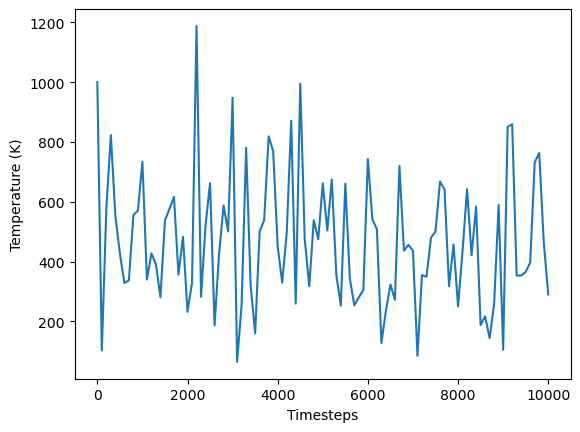

In [33]:
plt.plot(lmp.output.steps, lmp.output.temperature)
plt.xlabel("Timesteps")
plt.ylabel("Temperature (K)")

The temperature is only poorly equilibrate as the four atoms in the simulation cell are not sufficient. You can increase the supercell before assigning it to the LAMMPS job object by replacing the line `lmp.structure = structure` with `lmp.structure = structure.repeat([4,4,4])`

## Visualize the vibration of the individual atoms

Beyond combined properties like the change in temperature over time, we can also analyse the vibration of the atoms in the xy-plane. For this we divide the array of positions `lmp.output.positions` into two separate arrays one for the x-coordinates and one for the y-coordinates and then plot both combined in a two dimensional histogram.

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_839/4061323447.py:2: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('x [$\AA$]')
/tmp/ipykernel_839/4061323447.py:3: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('y [$\AA$]')


Text(0, 0.5, 'y [$\\AA$]')

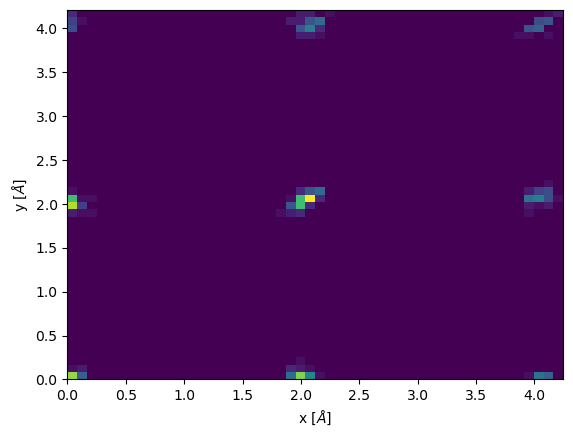

In [34]:
plt.hist2d(lmp.output.positions[:, :, 0].flatten(), lmp.output.positions[:, :, 1].flatten(), bins=50)
plt.xlabel('x [$\AA$]')
plt.ylabel('y [$\AA$]')

# Different levels of output

The easiest way to access the output of a pyiron job object is using the `output` property as demonstrated above. Internally, pyiron converts the underlying LAMMPS output files `log.lammps` and `dump.out` to `numpy` arrays and then stores these converted `numpy` arrays in an file using the hierachical data format (HDF5). 

## HDF5 interface

Each pyiron job object has one associated HDF5 file. To get the path of the HDF5 file for a particiular pyiron job object you can use `lmp.project_hdf5.file_name`.

In [35]:
lmp.project_hdf5.file_name

'/home/jovyan/test/lmp.h5'

The same HDF5 file can be accessed using the dicitonary notiation. The hierachy of the HDF5 format extends the hierachy of the filesystem, so the output properties like temperature and steps are located in the output group under the subgroup generic: 

In [36]:
lmp.content["output/generic"]

{'groups': [], 'nodes': ['cells', 'energy_pot', 'energy_tot', 'forces', 'indices', 'natoms', 'positions', 'pressures', 'steps', 'temperature', 'unwrapped_positions', 'velocities', 'volume']}

You can redo the plot from above using the direct access to the HDF5 file: 

/tmp/ipykernel_839/133915982.py:1: DeprecationWarning: pyiron_base.jobs.job.core.__getitem__ is deprecated: Use job.output for results, job.files to access files; job.content to access HDF storage and job.child_project to access children of master jobs..
  plt.plot(lmp["output/generic/steps"], lmp["output/generic/temperature"])


Text(0, 0.5, 'Temperature (K)')

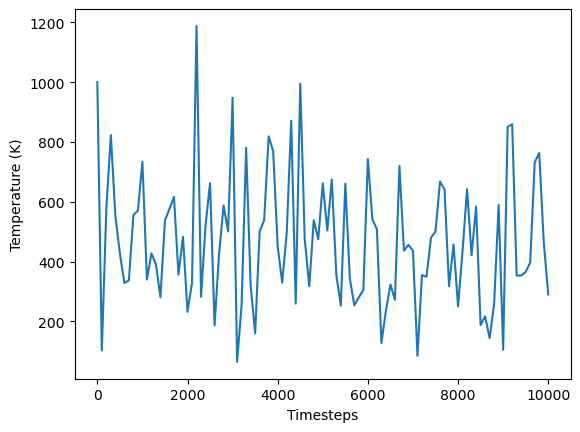

In [37]:
plt.plot(lmp["output/generic/steps"], lmp["output/generic/temperature"])
plt.xlabel("Timesteps")
plt.ylabel("Temperature (K)")

The advantage of the HDF5 interface is that the job object does not have to be reloaded from the database. Rather than calling `pr.load(job_name)` you can use `pr.inspect(job_name)` to access the job object without reloading it. This inspect mode acts like a pointer on the HDF5 file. The capabilities of the inspect mode are introduced in more detail in the following tutorial. 

## Direct access to the output files

In case you modified the LAMMPS input files, or in case you are interested in a specific property which is currently not parsed by the LAMMPS output parser, you can directly access the output files from the python interface. The output files are located in the working directory of the job object.

In [38]:
lmp.working_directory

'/home/jovyan/test/lmp_hdf5/lmp'

Still by default they are compressed, so access them we have to decompress the output files by calling the `decompress()` function of the job object:

In [39]:
lmp.decompress()

Now the output files can be accessed in the same way like the output properties stored in the HDF5 file using the dictionary like notation:

In [40]:
lmp["log.lammps"]

/tmp/ipykernel_839/2375576541.py:1: DeprecationWarning: pyiron_base.jobs.job.core.__getitem__ is deprecated: Use job.output for results, job.files to access files; job.content to access HDF storage and job.child_project to access children of master jobs..
  lmp["log.lammps"]


['LAMMPS (29 Aug 2024)\n',
 'OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)\n',
 '  using 1 OpenMP thread(s) per MPI task\n',
 'units metal\n',
 'dimension 3\n',
 'boundary p p p\n',
 'atom_style atomic\n',
 'read_data structure.inp\n',
 'Reading data file ...\n',
 '  orthogonal box = (0 0 0) to (4.05 4.05 4.05)\n',
 '  1 by 1 by 1 MPI processor grid\n',
 '  reading atoms ...\n',
 '  4 atoms\n',
 '  read_data CPU = 0.001 seconds\n',
 'include potential.inp\n',
 'pair_style eam/alloy\n',
 'pair_coeff * * NiAl02.eam.alloy Ni Al\n',
 'fix ensemble all npt temp 500.0 500.0 0.1 iso 0.0 0.0 1.0\n',
 'variable dumptime  equal 100\n',
 'variable thermotime  equal 100\n',
 'timestep 0.001\n',
 'velocity all create 1000.0 61040 dist gaussian\n',
 'dump 1 all custom ${dumptime} dump.out id type xsu ysu zsu fx fy fz vx vy vz\n',
 'dump 1 all custom 100 dump.out id type xsu ysu zsu fx fy fz vx vy vz\n',
 'dump_modify 1 sort id format line "%d %d %20.15g %20.15g %2

# Publish your results

To support users in publishing their simulation protocols and the results derived from corresponding calculation pyiron provides a `list_publications()` function to list all publication involved in creating the simulation protocol. In this particular case these are four publication: 

* the pyiron paper, as pyiron was used to develop the simulation protocol.
* the ASE paper, as ASE was used to create the atomistic structure.
* the LAMMPS paper, as LAMMPS was used to execute the calculation.
* the paper for the interatomic potential which defines the interaction between the atoms.

In [41]:
pr.list_publications()

,author,title,journal,volume,pages,issn,doi,url,year,number,publisher
0,"[Jan Janssen, Sudarsan Surendralal, Yury Lysogorskiy, Mira Todorova, Tilmann Hickel, Ralf Drautz, Jörg Neugebauer]",pyiron: An integrated development environment for computational materials science,Computational Materials Science,161,24 - 36,0927-0256,https://doi.org/10.1016/j.commatsci.2018.07.043,http://www.sciencedirect.com/science/article/pii/S0927025618304786,2019,NaN,NaN
1,"[Ask Hjorth Larsen, Jens Jørgen Mortensen, Jakob Blomqvist, Ivano E Castelli, Rune Christensen, Marcin Dułak, Jesper Friis, Michael N Groves, Bjørk Hammer, Cory Hargus, Eric D Hermes, Paul C Jenni...",The atomic simulation environment—a Python library for working with atoms,Journal of Physics: Condensed Matter,29,273002,NaN,NaN,http://stacks.iop.org/0953-8984/29/i=27/a=273002,2017,27,NaN
2,[Steve Plimpton],Fast Parallel Algorithms for Short-Range Molecular Dynamics,Journal of Computational Physics,117,1-19,0021-9991,10.1006/jcph.1995.1039,http://www.sciencedirect.com/science/article/pii/S002199918571039X,1995,1,NaN
3,"[Y. Mishin, M. J. Mehl, D. A. Papaconstantopoulos]",Embedded-atom potential for B2-NiAl,Physical Review B,65,224114,NaN,10.1103/physrevb.65.224114,https://doi.org/10.1103%2Fphysrevb.65.224114,2002,22,American Physical Society (APS)


# Summary

In this first pyiron LAMMPS tutorial you learned about the three most fundamental objects in an atomistic simulation with pyiron, namely the project object, the atomistic structure object and the LAMMPS job object. You also learned how to create both structure objects and LAMMPS job objects from the project object and finally the tutorial demonstrated the basic settings to setup, run and analyse your LAMMPS simulation. 